# **The Navier-Stokes equations**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Navier-Stokes equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

# **About the code**

In [ ]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
    
from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

--2023-04-11 15:36:57--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4156 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.06K  --.-KB/s    in 0s      

2023-04-11 15:36:58 (37.0 MB/s) - ‘/tmp/fenics-install.sh’ saved [4156/4156]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/bef019f/releases/pybind11-install.s

# **Introduction**

The Navier-Stokes equations take the form

$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$(\dot u + (u\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term.

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula: 

$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$

with $\Phi\in V$ a fuinction for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization, 

$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=1$), and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder). 

The Reynolds number is defined as $Re=\frac{UD}{\nu}$

To read more about how to use similar methods for more complex problems, see e.g. 

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

**Define domain and mesh**

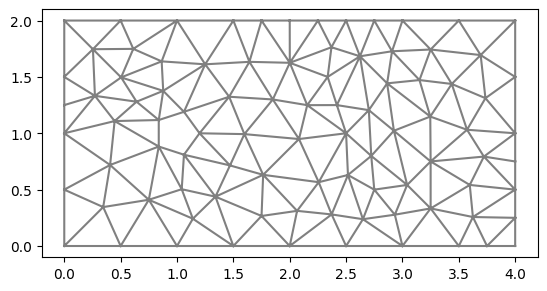

In [ ]:
# Define rectangular domain 
L = 4
H = 2

# Define circle
xc = 1.0
yc = 0.5*H
rc = 0.2

#Q2 extra assignment 
#L=2.2
#H=0.41
#xc = 0.2
#yc = 0.2
#rc = 0.05

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0) 

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)
      
left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh) 
resolution = 8
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(xc, yc)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [ ]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions 
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

**Define boundary conditions**

In [ ]:
# Define boundary conditions 
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0) 

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

# Examples of time dependent and stationary inflow conditions
#uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
#uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)
uin = 1.0

# extra question Q2
#XMIN = 0.0; XMAX = L
#YMIN = 0.0; YMAX = H
#Um = 1.5
#uin = Expression("4*Um*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", YMAX=YMAX,Um=Um, element = V.ufl_element()) 

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

# Examples of time dependent and stationary inflow conditions
#uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
#uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)

uin = 1.0
bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
pout = 0.0
#bcp0 = DirichletBC(Q, pin, dbc_left) 
bcp1 = DirichletBC(Q, pout, dbc_right)

#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
bcp = [bcp1]

# Define measure for boundary integration  
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# **Results**

**Define flow parameters**

In [ ]:
# Set viscosity
nu = 4.0e-3 # Re = U2rc/nu = 0.4/nu
2*rc/nu # Re 

#extra question Q2
#Um=1.5
#U_mean = 4*Um*H/2*H/2/H/H
#2*rc*U_mean*2/3/nu # Re 


100.0

**Define method parameters**

In [ ]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step  
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Set parameters for nonlinear and lienar solvers 
num_nnlin_iter = 5 
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default" 

# Time step length 
dt = 0.5*mesh.hmin() 

**Define variational problem**

In [ ]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = h*u_mag

# Mean velocities for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx 
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx 
ap = lhs(Fp)
Lp = rhs(Fp)

**Compute force on boundary**

In [ ]:
# Define the direction of the force to be computed 
phi_x = 0.0
phi_y = 1.0

#psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
psi_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
psi = interpolate(psi_expression, V)

Force = inner((u1 - u0)/dt + grad(um1)*um1, psi)*dx - p1*div(psi)*dx + nu*inner(grad(um1), grad(psi))*dx

#plt.figure()
#plot(psi, title="weight function psi")

# Force normalization
D = 2*rc
normalization = -2.0/D

**Set plotting variables and open export files**

In [ ]:
# Open files to export solution to Paraview
file_u = File("results-NS/u.pvd")
file_p = File("results-NS/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 10

# Force computation data 
force_array = np.array(0.0)
force_array = np.delete(force_array, 0)
time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Time stepping algorithm**

Time t = 0.13091486480653436


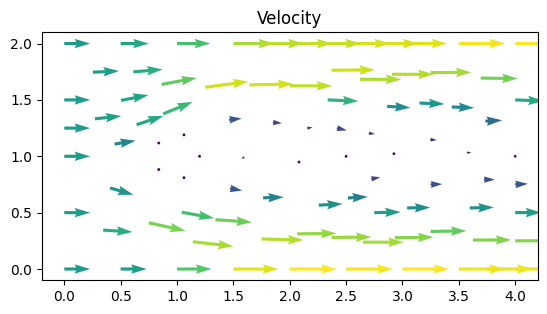

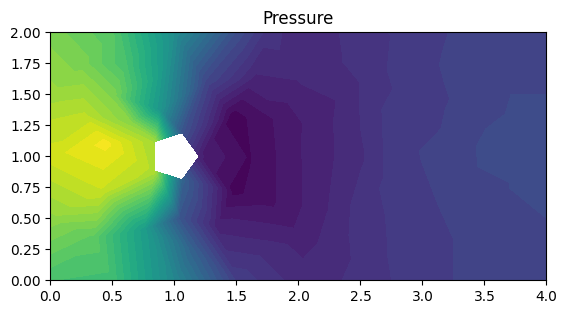

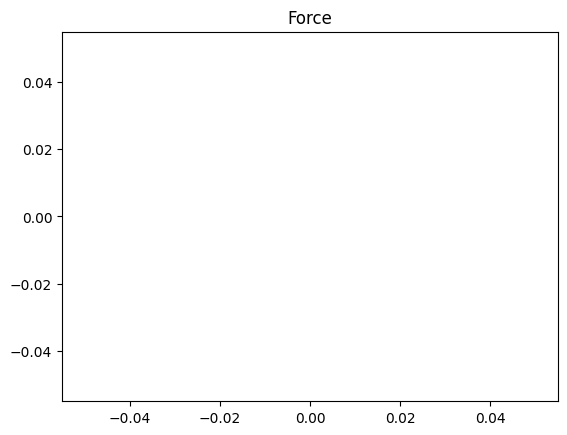

Time t = 3.011041890550292


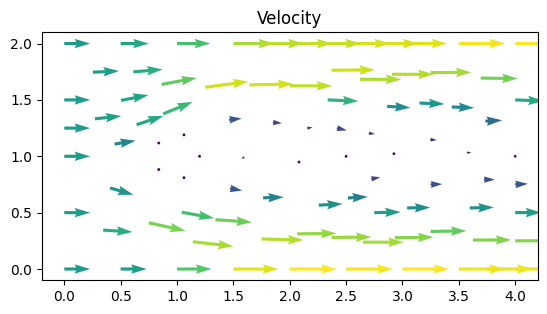

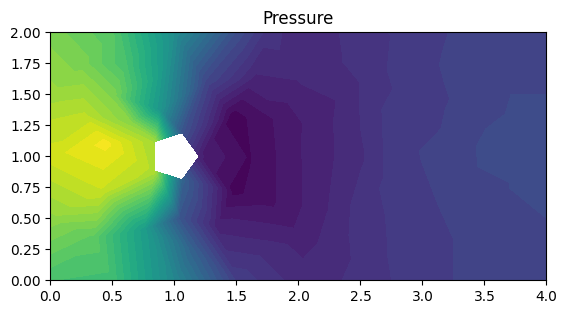

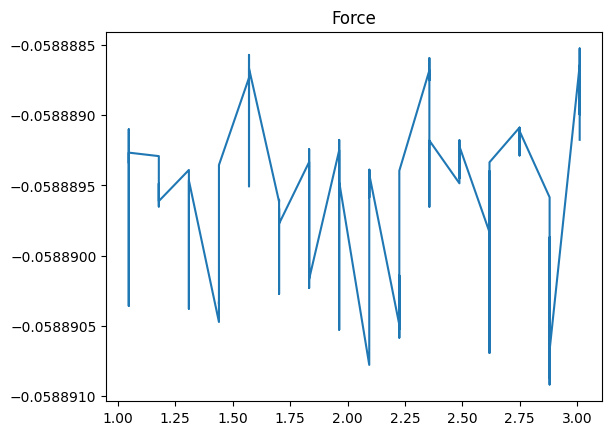

Time t = 6.022083781100587


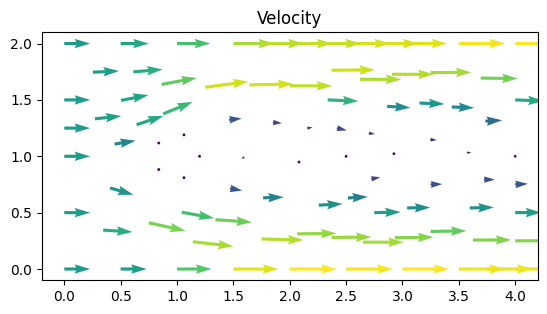

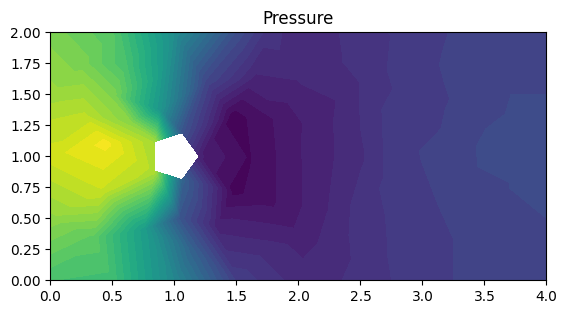

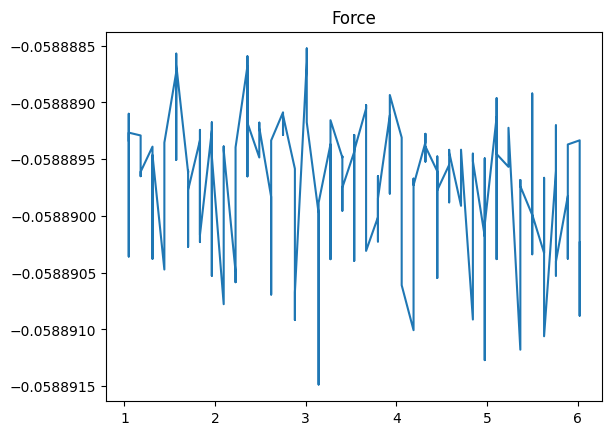

Time t = 9.033125671650883


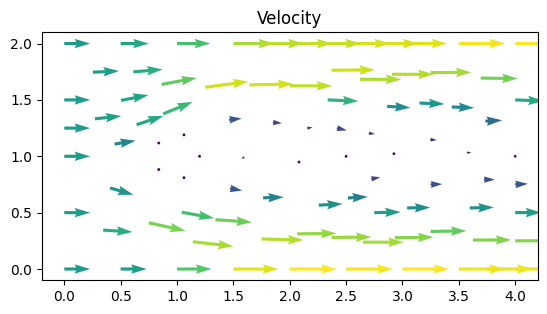

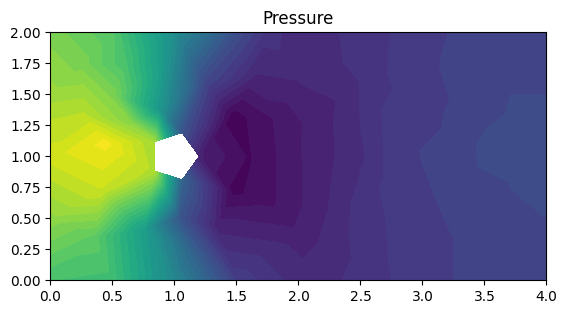

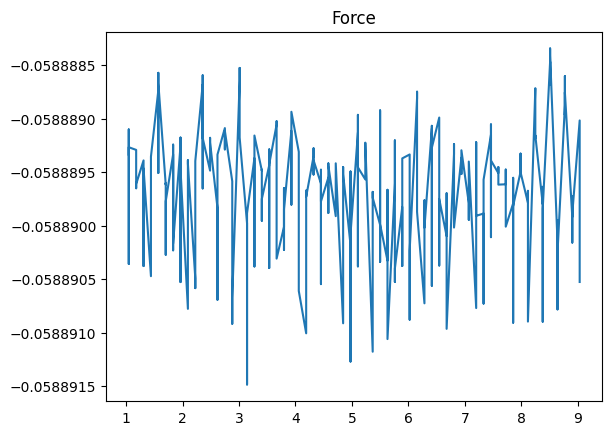

Time t = 12.044167562201178


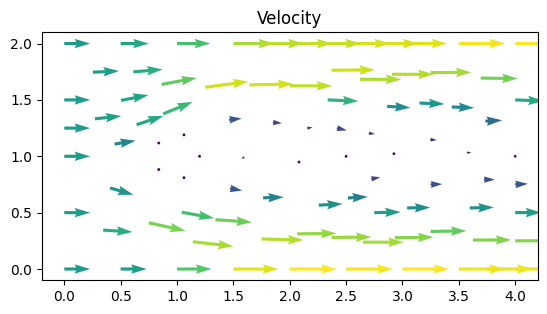

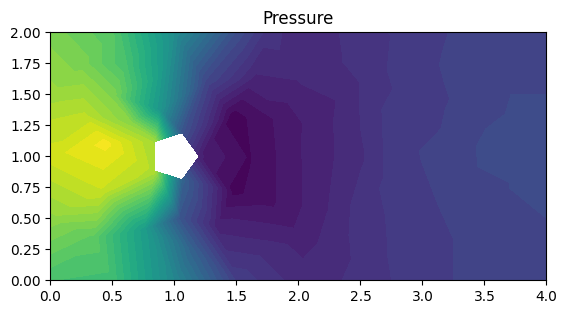

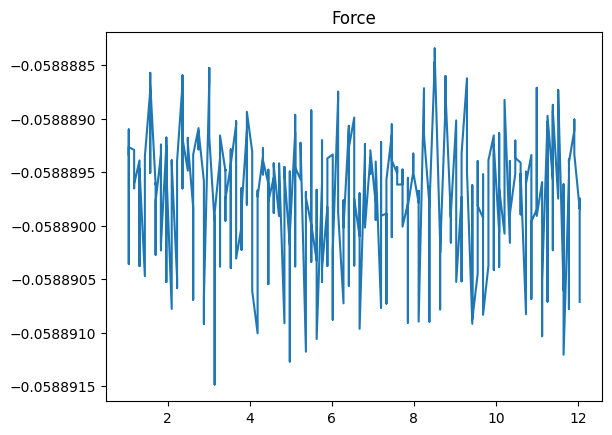

Time t = 15.055209452751473


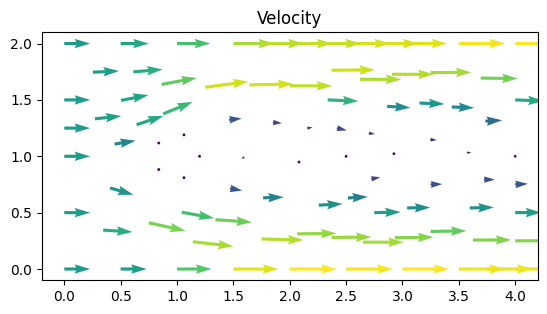

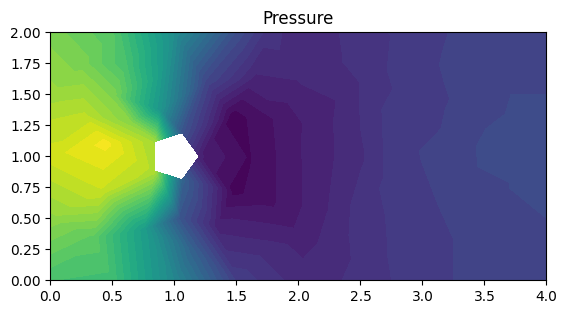

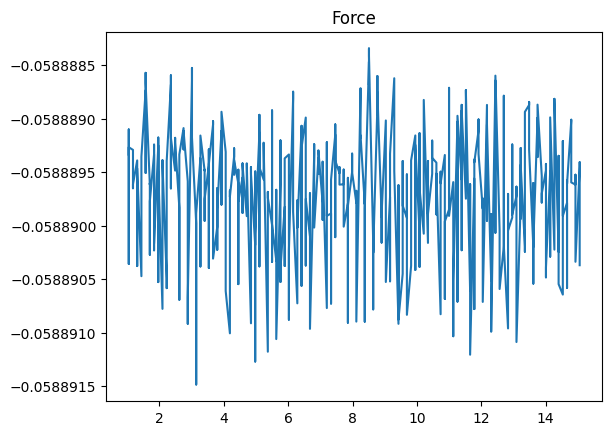

Time t = 18.06625134330177


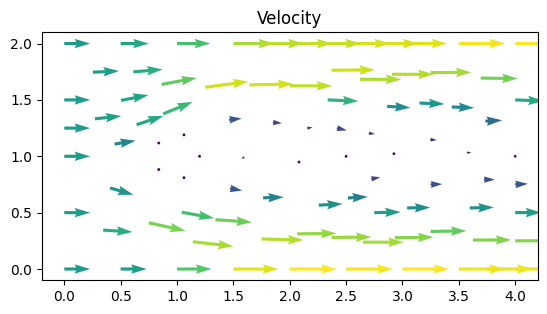

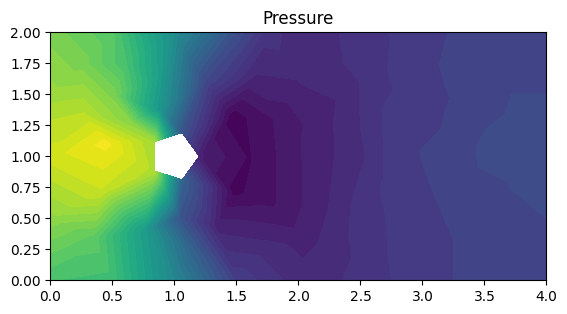

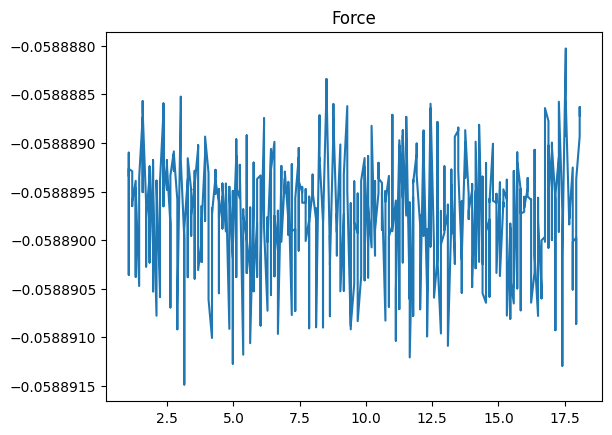

Time t = 21.077293233852064


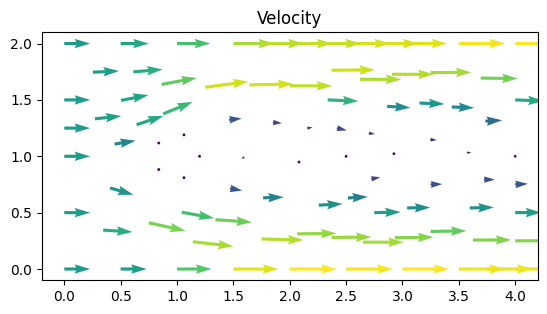

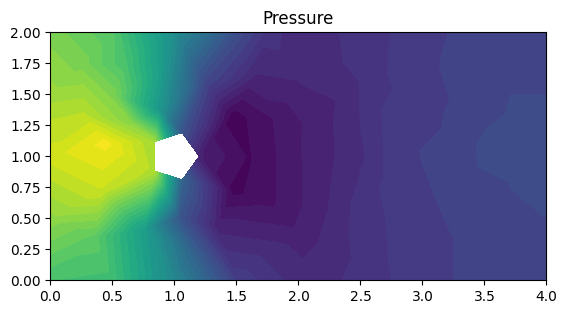

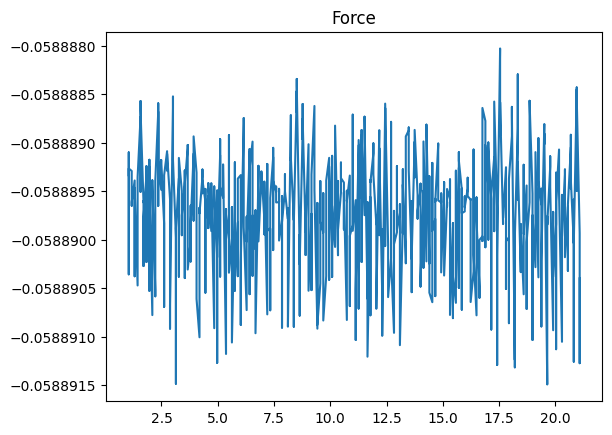

Time t = 24.08833512440236


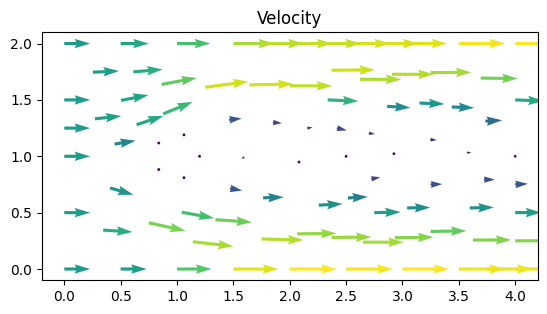

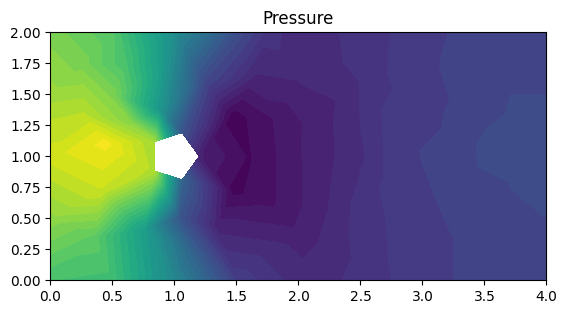

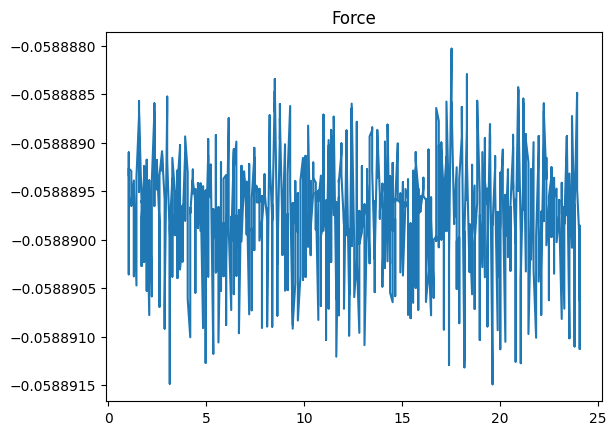

Time t = 27.099377014952655


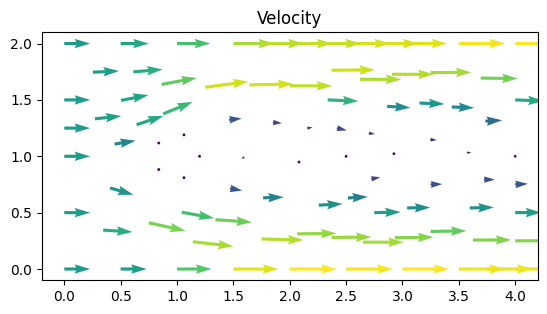

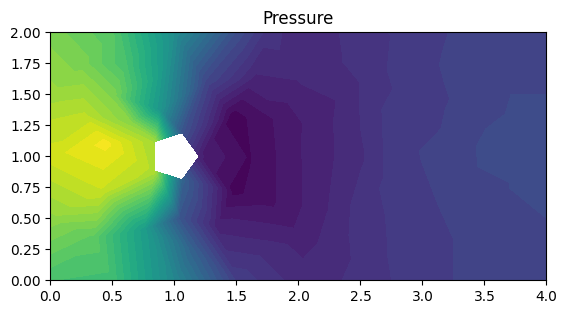

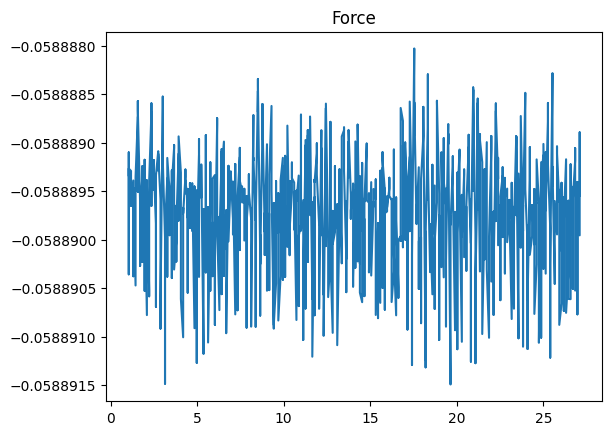

In [ ]:
!rm results-NS/*

# Time stepping 
T = 30
t = dt
while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t) 
    #print(s)

    pin.t = t
    #uin.t = t

    # Solve non-linear problem 
    k = 0
    while k < num_nnlin_iter: 
        
        # Assemble momentum matrix and vector 
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution 
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap) 
        bp = assemble(Lp)

        # Compute pressure solution 
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        # Compute force
        F = assemble(Force)
        if (t > start_sample_time):
          force_array = np.append(force_array, normalization*F)
          time = np.append(time, t)

        k += 1

    if t > plot_time:     
        
        s = 'Time t = ' + repr(t) 
        print(s)
    
        # Save solution to file
        file_u << u1
        file_p << p1

        # Plot solution
        plt.figure()
        plot(u1, title="Velocity")

        plt.figure()
        plot(p1, title="Pressure")
        

        plot_time += T/plot_freq
        
        plt.show()

        plt.figure()
        plt.title("Force")
        plt.plot(time, force_array)
        plt.show()

    # Update time step
    u0.assign(u1)
    t += dt

#!tar -czvf results-NS.tar.gz results-NS
#files.download('results-NS.tar.gz')

# **Discussion**



**Abstract**

The purpose of this lab is to solve the equations Navier Stokes and to observe the creation of turbulence behind a cylinder. The drag and lift forces will be computed as the Strouhal number for different Reynolds number. The Von Karman vortex will be observed. Then I will study the impact of the resolution of the mesh on the turbulence and the calculation of the drag and lift forces.

**Introduction**

1. Reynolds number

Compute the Reynolds number based on the inflow velocity U and the diameter D of the cylinder. Compare simulations for Reynolds numbers Re = 1, 10, 100, 1000. For which Reynolds numbers is the flow unsteady and steady, respectively? 

2. Drag and lift coefficients

Compute the drag and lift coefficientsLinks to an external site., and the Strouhal numberLinks to an external site., for the cylinder at the different Reynolds numbers (Re = 1, 10, 100, 1000). Verify that the von Karman vortex streetLinks to an external site. has a Strouhal number of St≈0.2. 

3. Mesh resolution

Compare the solution for Re=100 under the different mesh resolutions h=1/8, 1/16, 1/32. Describe how the simulations change with respect to drag and lift coefficients and the Strouhal number. 

2. Benchmark

Modify the simulation problem to match the test case 2D-2 (unsteady) in the benchmark report by Schäfer and Turek. Links to an external site.

**Methods**

The Navier Stokes equations are solved by the FEM on a unstructured 2D mesh. The boundary conditions are homogeneous Dirichlet boundaries at the top, at the bottom and around the cylinder. There are also an inflow and an outflow boundary condition on the left part and the right part of the domain. These two boundaries can be changed in order to choose the direction of the flow. 

**Results**


Q1 :

The Reynolds number is $Re=\frac{UD}{\nu}=\frac{U2r_{c}}{\nu}$. Or in this case, $U = 1$ and $r_{c} = 0.2$. Therefore $Re=\frac{2r_{c}}{\nu}$ which leads to $Re = 1$ when $\nu = 0.4$ ; $Re = 10$ when $\nu = 0.04$ ; $Re = 100$ when $\nu = 0.004$ and $Re = 1000$ when $\nu = 0.0004$.

I expect to see the following behaviour :
- For Re = 1, a fully laminar flow with a single separation point (steady flow). That is what we can observe.
- For Re = 10, a flow that has now 2 separation points and some turbulence behind the ciruclar hole (steady flow). It's hard to distinguish the separation points, but the flow remains steady and I start to observe a turbulent wake behind the circular hole.
- For Re = 100, the flow should present the Von Karman vortices around $Re = 300$ (which implies that the flow is unsteady), that is the case. 
- For Re = 1000, the flow would present strong Von Karman vortices. It's indeed what the simulation shows with strong unsteady vortices.

=> For Re = 200 I start to observe an unsteady flow that is oscillating. I would therefore state that the flow is steady for Re < 200 and unsteady for Re > 200.

Q2 :

The drag coefficient is defined as : $c_{d}=\frac{2F_{d}}{\rho u^2 A}$. In this case, $U = 1$ ; $\rho = 1$ and $A = \pi r_{c}^2 = 0.126$. Therefore, $c_{d} = 15.9F_{d}$.
The lift coefficient is defined as : $c_{L}=\frac{2F_{L}}{\rho u^2 A}$. In this case, $U = 1$ ; $\rho = 1$ and $A = \pi r_{c}^2 = 0.126$. Therefore, $c_{L} = 15.9F_{d}$.
The Strouhal number is defined as : $S_{t}=\frac{f.2r_{c}}{U} = 0.4f$.

- For Re = 1 : $F_{d} = 17.1$ and thus $c_{d} = 272$ ; $F_{L} = 0.038$ and thus $c_{L} = 0.6$ ; the flow is steady and therefore $f = 0$ and $S_{t} = 0$.
- For Re = 10 : $F_{d} = 3.6$ and thus $c_{d} = 57$ ; $F_{L} = 0.05$ and thus $c_{L} = 0.8$ ; the flow is steady and therefore $f = 0$ and $S_{t} = 0$.
- For Re = 100 : The forces are oscillating the mean of the drag force and therefore the mean of the drag coefficient : $F_{dmean} = 1.64$ and thus $c_{dmean} = 26,1$ the magnitude is $F_{dmagn} = 0.08$ and thus $c_{dmagn} = 1,27$; same for the lift : $F_{Lmean} = 0.05$ and thus $c_{Lmean} = 0.8$ and $F_{Lmagn} = 0.4$ and thus $c_{Lmagn} = 6.4$ ; the flow is unsteady and I observe the main frequency $f = 0.5$ and $S_{t} = 0.2$. For the Von Karman vortices, the Strouhal number is around 0.2 which is very close to what I have found here.
- For Re = 1000 : The forces are oscillating the mean of the drag force and therefore the mean of the drag coefficient : $F_{dmean} = 1.57$ and thus $c_{dmean} = 25$ the magnitude is $F_{dmagn} = 0.11$ and thus $c_{dmagn} = 1,8$; same for the lift : $F_{Lmean} = 0.05$ and thus $c_{Lmean} = 0.8$ and $F_{Lmagn} = 0.6$ and thus $c_{Lmagn} = 9.6$ ; the flow is unsteady and I observe the main frequency $f = 0.55$ and $S_{t} = 0.22$. 

For the Von Karman vortices, the Strouhal number is around 0.2 which is very close to what I have found at $Re = 100$ and $Re = 1000$.

Q3 :

The higher is the precision of the mesh, the more precise should be the simulation (if we assume that the simulation is stable).

- For h = 1/32 : $F_{dmean} = 1.64$ and thus $c_{dmean} = 26,1$ ; $F_{dmagn} = 0.08$ and thus $c_{dmagn} = 1,27$ ; $F_{Lmean} = 0.05$ and thus $c_{Lmean} = 0.8$ ; $F_{Lmagn} = 0.6$ and thus $c_{Lmagn} = 9.6$ ; the flow is unsteady with a main frequency of around $f = 0.5$ and $S_{t} = 0.2$.
- For h = 1/16 : $F_{dmean} = 2.09$ and thus $c_{dmean} = 33.2$ ; $F_{dmagn} = 0.01$ and thus $c_{dmagn} = 0.16$ ; $F_{Lmean} = -0.01$ and thus $c_{Lmean} = -0.16$ ; $F_{Lmagn} = 0.2$ and thus $c_{Lmagn} = 1.6$ ; the flow is unsteady with a main frequency of around $f = 0.5$ and $S_{t} = 0.2$.
- For h = 1/8 : $F_{dmean} = 3$ and thus $c_{dmean} = 47$ ; $F_{dmagn} = 0.0$ and thus $c_{dmagn} = 0.0$ ; $F_{Lmean} = -0.06$ and thus $c_{Lmean} = -0.95$ ; $F_{Lmagn} = 0.0$ and thus $c_{Lmagn} = 0.0$ ; the flow is unsteady with a main frequency of around $f = 0.0$ and $S_{t} = 0.0$.

I observe a decrease of the lift coefficient and therefore a high error in the prediction of the lift when the precision is decreasing. On the contrary the drag coefficient is overestimated for a low precision. That can be explained by the fact that with a precision of 16, the circular hole is defined by only 5 or 6 cells and even worse with a precision of 8. In addition, I don't observe anymore the oscillations for the case with a precision of 8. That can be explained by the fact that the mesh is not precise enough to compute the turbulence effect. 

Extra question Q2 :

For this question I modify the mesh in order to match the domain of the test case 2D.2. I put $L = 2.2, H = 0.41, rc = 0.05, xc = 0.2$ and $yc = 0.2$. I also need to modify the inlet boundary condition with a velocity inflow that is non uniform : $U_{inlet} = 4U_{m}y(H-y)/H^2$ and $V = 0$. Finally I have a new definition of the Reynolds number which is $Re = 2/3U_{inlet}(0,H/2,t)2r_{c}/ν = 0.2U_{m}/3\nu=0.1/\nu$. Here are the results of the simulation with these inputs :

The drag force oscillates around $Fd_{mean} = 3.43$ with a magnitude of $Fd_{magn} = 0.05$. We have therefore $cd_{mean} = 873.4$ with a magnitude of $cd_{magn} = 12.7$.

The lift force oscillates around $Fl_{mean} = 0.4$ with a magnitude of $Fl_{magn} = 0.6$. We have therefore $cl_{mean} = 101.9$ with a magnitude of $cl_{magn} = 152.8$.

The frequency is $f = 45/23 = 1.95$ (number of peaks/time). Therefore, the Strouhal number is $S_{t}=\frac{f.2r_{c}}{U(0,H/2,t)} = 0.1f = 0.195$. We find again the value 0.2 !

**Discussion**

A stabilized finite element method was implemented in FEniCS to solve the Navier-Stokes equations in 2D. The method was tested for the model problem of flow past a circular obstacle, and for a high enough Reynolds number and sufficient mesh resolution [a von Karman vortex street developed as expected.](https://en.wikipedia.org/wiki/Kármán_vortex_street) 